In [1]:
import random
import numpy as np

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

from models.networks.ofa_resnets import OFAResNets
from ofa.utils.common_tools import DistributedMetric
from ofa.utils.face_data import PairFaceDataset

In [2]:
seed = 0

# set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
n_classes = 10575
depth_list = "3,4"
expand_list = "1"
width_mult_list = "1.0"

In [4]:
# build net from args
width_mult_list = [
    float(width_mult) for width_mult in width_mult_list.split(",")
]
width_mult_list = (
    width_mult_list[0]
    if len(width_mult_list) == 1
    else width_mult_list
)
# ks_list = [int(ks) for ks in ks_list.split(",")]
expand_list = [int(e) for e in expand_list.split(",")]
depth_list = [int(d) for d in depth_list.split(",")]

print(depth_list)

[3, 4]


In [5]:
def face_accuracy(labels, scores, FPRs):
    from sklearn import metrics
    from scipy.optimize import brentq
    from scipy.interpolate import interp1d

    # eer and auc
    # len(labels) = 6000
    # scores shape = 1048576 -> must be 6,000
    fpr, tpr, _ = metrics.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * metrics.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    # pos_num = labels.count(1)
    pos_num = len(labels.nonzero()[0])
    neg_num = len(labels) - pos_num
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return [('ACC', ACC), ('EER', EER), ('AUC', AUC)] + TPRs

In [6]:
def update_face_metric(metric_dict, feats, dataset):
    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    dim = feats.shape[-1]

    # pair-wise scores
    feats = F.normalize(feats.reshape(-1, dim), dim=1)
    feats = feats.reshape(-1, 2, dim)
    feats0 = feats[:, 0, :]
    feats1 = feats[:, 1, :]
    scores = torch.sum(feats0 * feats1, dim=1).tolist()

    retrieval_targets = dataset.retrieval_targets

    results = face_accuracy(retrieval_targets, scores, FPRs)
    results = dict(results)
    metric = ['ACC']
    # metric_dict["top1"].update(results[metric[0]], scores.szie(0))
    metric_dict["top1"].update(results[metric[0]], len(scores))

In [7]:
def get_metric_dict():
    return {
        "top1": DistributedMetric("top1"),
        "top5": DistributedMetric("top5"),
    }

In [8]:
def get_metric_vals(metric_dict, return_dict=False):
    if return_dict:
        return {key: metric_dict[key].avg.item() for key in metric_dict}
    else:
        return [metric_dict[key].avg.item() for key in metric_dict]

In [9]:
# Test code
def test(net, testloader, device, test_dataset):
    net.eval()
    
    mb_size = 128
    n_samples = len(test_dataset)
    # output_dim = max(net.input_channel) * 32
    # output_dim = net.module.feature_size # 2048
    output_dim = 2048 # 2048
    feats = torch.zeros([n_samples, 2, output_dim], dtype=torch.float32).to(device)
    metric_dict = get_metric_dict()

    with torch.no_grad():
        for idx, data in  enumerate(testloader):
            query_x, retrieval_x, labels = data
            query_x, retrieval_x, labels = query_x.to(device), retrieval_x.to(device), labels.to(device)
            
            # compute output
            # qeury_feat = net(query_x, outputs='features')
            # retrieval_feat = net(retrieval_x, outputs='features')

            # qeury_feat = net.module.features(query_x)
            # retrieval_feat = net.module.features(retrieval_x)

            qeury_feat = net(query_x, outputs='features')
            retrieval_feat = net(retrieval_x, outputs='features')

            batch_start_idx = idx * mb_size
            actual_batch_size = qeury_feat.size(0)
            batch_end_idx = batch_start_idx + actual_batch_size

            feats[batch_start_idx:batch_end_idx, 0, :] = qeury_feat
            feats[batch_start_idx:batch_end_idx, 1, :] = retrieval_feat

            # measure accuracy
            update_face_metric(metric_dict, feats.cpu(), test_dataset)

    return get_metric_vals(metric_dict)

In [10]:
net = OFAResNets(
        n_classes = n_classes, 
        depth_list = depth_list,
        expand_ratio_list = expand_list,
        width_mult_list = width_mult_list
    )

net.to(device)

OFAResNets(
  (input_stem): ModuleList(
    (0): DynamicConvLayer(
      (conv): DynamicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      )
      (bn): DynamicBatchNorm2d(
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv): DynamicConvLayer(
        (conv): DynamicConv2d(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
        (bn): DynamicBatchNorm2d(
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (act): ReLU(inplace=True)
      )
      (shortcut): IdentityLayer()
    )
    (2): DynamicConvLayer(
      (conv): DynamicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      )
      (bn): DynamicBatchNorm2d(
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [11]:
test_path = '/home/heonsung/sustainable-ai/nas/dataset/test_lfw/'

transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_dataset = PairFaceDataset(root=test_path, 
                                   transform=transform, 
                                   data_annot=test_path)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Load lfw annotation file.


In [12]:
# load trained supernet
init = torch.load("exp/depth/checkpoint/model_best.pth.tar", map_location="cpu")["state_dict"]
net.load_state_dict(state_dict=init)

### Test High Acc SubNet

In [13]:
# get subnet (mid)
net.set_active_subnet(d=[3,4,4,4])
subnet = net.get_active_subnet()

model_size = sum(p.numel() for p in subnet.parameters() if p.requires_grad)
model_size_in_million = model_size / 1e6
print("Model Size: {:.2f} M".format(model_size_in_million))

test_accuracy = test(subnet, test_loader, device, test_dataset)
print(f'Test Accuracy: {test_accuracy[0]:.2f}%')

Model Size: 412.54 M
Test Accuracy: 72.00%


### Test Mid SubNet

In [14]:
# get subnet (mid)
net.set_active_subnet(d=[2,2,2,4])
subnet = net.get_active_subnet()

model_size = sum(p.numel() for p in subnet.parameters() if p.requires_grad)
model_size_in_million = model_size / 1e6
print("Model Size: {:.2f} M".format(model_size_in_million))

test_accuracy = test(subnet, test_loader, device, test_dataset)
print(f'Test Accuracy: {test_accuracy[0]:.2f}%')

Model Size: 405.32 M
Test Accuracy: 70.30%


### Test Min SubNet

In [13]:
# get subnet (min)
net.set_active_subnet(d=[2,2,2,2])
subnet = net.get_active_subnet()

model_size = sum(p.numel() for p in subnet.parameters() if p.requires_grad)
model_size_in_million = model_size / 1e6
print("Model Size: {:.2f} M".format(model_size_in_million))

test_accuracy = test(subnet, test_loader, device, test_dataset)
print(f'Test Accuracy: {test_accuracy[0]:.2f}%')

Model Size: 382.24 M
Test Accuracy: 69.96%


# Plot

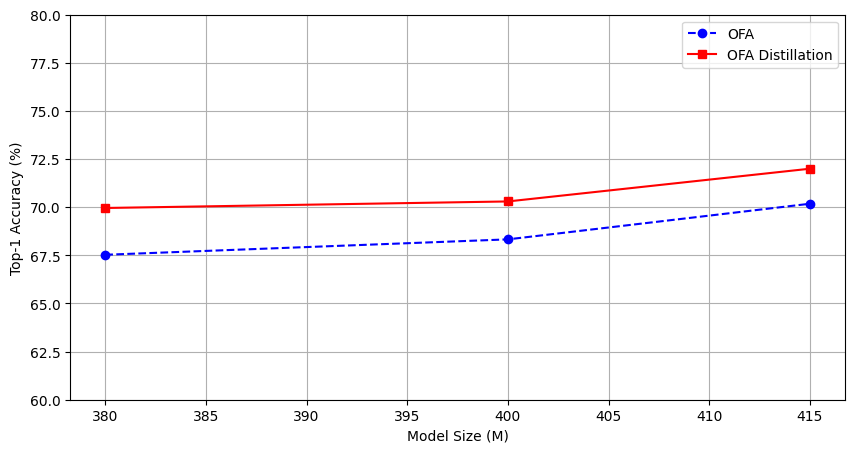

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Adjusting the plot to display only three data points per line, without the connecting lines, to match the new request.
model_size = np.array([380, 400, 415])
ofa_accuracy = np.array([67.53, 68.33, 70.18])
ofa_distill_accuracy = np.array([69.96, 70.30, 72.00])

# Create the plot
plt.figure(figsize=(10, 5))

# Plot three selected points for each series and connect them with lines
plt.plot(model_size, ofa_accuracy, marker='o', color='blue', linestyle='--', label='OFA')
plt.plot(model_size, ofa_distill_accuracy, marker='s', color='red', linestyle='-', label='OFA Distillation')

# Adding titles and labels
plt.xlabel('Model Size (M)')
plt.ylabel('Top-1 Accuracy (%)')

# Set the y-axis limits
plt.ylim(60, 80)

# Adding a legend
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.show()
